# QCoDeS Example with Tektronix Keithley 2450 Source Meter

In this example we will setup a number of [four-wire measurements](https://en.wikipedia.org/wiki/Four-terminal_sensing) with the 2540 source meter. We attach a variable resistor to the front terminals and determine if we can measure the correct resistance.

In [1]:
from pyvisa import VisaIOError

from qcodes.dataset import (
    Measurement,
    initialise_database,
    new_experiment,
    plot_dataset,
)
from qcodes.instrument_drivers.Keithley import Keithley2450

In [2]:
keithley = Keithley2450("keithley", "GPIB0::18::INSTR")

Connected to: KEITHLEY INSTRUMENTS 2450 (serial:04451117, firmware:1.6.7c) in 0.08s


In [3]:
keithley.reset()

## Single point measurements 

Attach a variable resistor to the front and source a current 

In [4]:
keithley.terminals("front")
keithley.source.function("current")
keithley.source.current(1E-6)  # Put 1uA through the resistor
current_setpoint = keithley.source.current()

voltage = keithley.sense.function("voltage")
with keithley.output_enabled.set_to(True):
    voltage = keithley.sense.voltage()

print("Approx. resistance: ",  voltage/current_setpoint)

Approx. resistance:  1022.3210000000001


We can also directly measure the resistance

In [5]:
voltage = keithley.sense.function("resistance")
with keithley.output_enabled.set_to(True):
    resistance = keithley.sense.resistance()

print("Measured resistance: ",  resistance)

Measured resistance:  996.9845


In 'current' mode, we cannot set/get a voltage and vice versa

In [6]:
try:
    keithley.source.voltage()
except AttributeError:
    function = keithley.source.function()
    print(f"In the '{function}' source mode the source module does not have a 'voltage' attribute")

In the 'current' source mode the source module does not have a 'voltage' attribute


This goes for both the source and sense subsystems 

In [7]:
try:
    keithley.sense.current()
except AttributeError:
    function = keithley.sense.function()
    print(f"In the '{function}' sense mode the sense module does not have a 'current' attribute")

In the 'resistance' sense mode the sense module does not have a 'current' attribute


We also need to make sure the output is enabled for use the measure (or 'sense') a current or voltage 

## Sweeping measurements 

The instrument has a build-in sweep system. For the first measurement, we drive a current through the resistor and measure the voltage accross it. 

In [8]:
initialise_database()
experiment = new_experiment(name='Keithley_2450_example', sample_name="no sample")

Sweep the current from 0 to 1uA in 10 steps and measure voltage

In [9]:
keithley.sense.function("voltage")
keithley.sense.auto_range(True)

keithley.source.function("current")
keithley.source.auto_range(True)
keithley.source.limit(2)
keithley.source.sweep_setup(0, 1E-6, 10)

keithley.sense.four_wire_measurement(True)

Starting experimental run with id: 188. 


([<matplotlib.axes._subplots.AxesSubplot at 0x1ce9f5622c8>], [None])

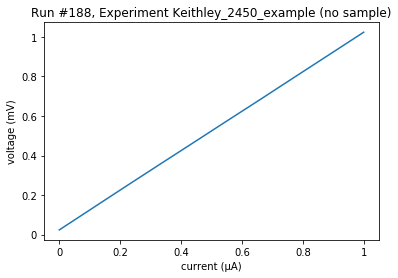

In [10]:
meas = Measurement(exp=experiment)
meas.register_parameter(keithley.sense.sweep)

with meas.run() as datasaver:
    datasaver.add_result((keithley.source.sweep_axis, keithley.source.sweep_axis()),
                         (keithley.sense.sweep, keithley.sense.sweep()))

    dataid = datasaver.run_id

plot_dataset(datasaver.dataset)

Sweep the voltage from 10mV in 10 steps and measure current 

In [11]:
keithley.sense.function("current")
keithley.sense.range(1E-5)
keithley.sense.four_wire_measurement(True)

keithley.source.function("voltage")
keithley.source.range(0.2)
keithley.source.sweep_setup(0, 0.01, 10)

Starting experimental run with id: 189. 


([<matplotlib.axes._subplots.AxesSubplot at 0x1cea1677a88>], [None])

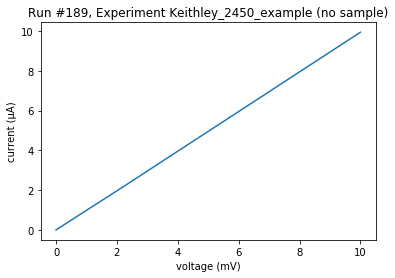

In [12]:
meas = Measurement(exp=experiment)
meas.register_parameter(keithley.sense.sweep)

with meas.run() as datasaver:
    datasaver.add_result((keithley.source.sweep_axis, keithley.source.sweep_axis()),
                         (keithley.sense.sweep, keithley.sense.sweep()))

    dataid = datasaver.run_id

plot_dataset(datasaver.dataset)

## To perform measurements with user-defined reading buffer

In [13]:
keithley.reset()

By default, when performing measurement, the value is stored in the default buffer "defbuffer1".

In [14]:
keithley.sense_function('current')
with keithley.output_enabled.set_to(True):
    data_point01 = keithley.sense.current()
    data_point02 = keithley.sense.current()
    data_point03 = keithley.sense.current()
print(f"The current measurements are {data_point01}, {data_point02}, {data_point03} A.")

The current measurements are -1.608374e-08, -1.818495e-08, -1.950789e-08 A.


We can use a user-defined reading buffer for measurement. The following example is to do a sweep measurement, and read extra data elements in addition to the measurement value with the new method "elements".

In [15]:
buffer_name = 'userbuff1'
buffer_size = 100
with keithley.buffer(buffer_name, buffer_size) as buff1:
    buff1.elements(['time', 'date', 'measurement', 'source_value_formatted'])
    keithley.source.sweep_setup(0, 1E-6, 10, buffer_name=buff1.buffer_name)
    data = keithley.sense.sweep()
    all_data = keithley.sense.sweep.get_selected()

"data" includes the numerical value of the measurement:

In [16]:
data

array([-1.772451e-08, -2.088747e-08, -2.159876e-08, -2.161518e-08,
       -2.155486e-08, -2.154403e-08, -2.157010e-08, -2.107971e-08,
       -2.079369e-08, -2.079450e-08])

"all_data" includes extra information specified by the "elements()" method:

In [17]:
all_data

['14:14:29',
 '06/10/2020',
 '-1.772451E-08',
 '+00.00507 mV',
 '14:14:29',
 '06/10/2020',
 '-2.088747E-08',
 '+00.00200 mV',
 '14:14:29',
 '06/10/2020',
 '-2.159876E-08',
 '+00.00116 mV',
 '14:14:30',
 '06/10/2020',
 '-2.161518E-08',
 '+00.00187 mV',
 '14:14:30',
 '06/10/2020',
 '-2.155486E-08',
 '+00.00098 mV',
 '14:14:30',
 '06/10/2020',
 '-2.154403E-08',
 '+00.00116 mV',
 '14:14:31',
 '06/10/2020',
 '-2.157010E-08',
 '+00.00190 mV',
 '14:14:31',
 '06/10/2020',
 '-2.107971E-08',
 '+00.00209 mV',
 '14:14:31',
 '06/10/2020',
 '-2.079369E-08',
 '+00.00269 mV',
 '14:14:32',
 '06/10/2020',
 '-2.079450E-08',
 '+00.00273 mV']

By using "with ... as ...:" to perform the measurement, there user-defined buffer is automatically removed after the measurement. **This is the recommanded way to use the user-defined buffer.**

In [18]:
try:
    buff1.size()
except VisaIOError as err:
    print(err)

('VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.', 'asking ":TRACe:POINts? \'userbuff1\'" to <Keithley2450: keithley>', 'getting keithley_userbuff1_size')


And we can still access the data in the default buffer:

In [19]:
buffer_name = 'defbuffer1'
buffer = keithley.buffer(buffer_name)

In [20]:
print(f"There are {buffer.number_of_readings()} data points in '{buffer_name}'.")

There are 3 data points in 'defbuffer1'.


The last reading is:

In [21]:
buffer.get_last_reading()

'-1.950789E-08'

We can get all 3 previously measured data as following:

In [22]:
buffer.get_data(1,3)

[-1.608374e-08, -1.818495e-08, -1.950789e-08]

And the original infomration are still there:

In [23]:
buffer.elements(["time", "measurement_formatted"])
buffer.get_data(1, 3)

['14:14:28',
 '-016.084 nA',
 '14:14:28',
 '-018.185 nA',
 '14:14:28',
 '-019.508 nA']

This is all the available elements, if none is requested, "measurement" will be used:

In [24]:
buffer.available_elements

{'date',
 'fractional_seconds',
 'measurement',
 'measurement_formatted',
 'measurement_status',
 'measurement_unit',
 'relative_time',
 'seconds',
 'source_value',
 'source_value_formatted',
 'source_value_status',
 'source_value_unit',
 'time',
 'timestamp'}

If the user gives a incorrect element name, error message will show which ones are correct:

In [25]:
try:
    buffer.elements(['dates'])
except ValueError as err:
    print(err)


("'dates' is not in {'measurement', 'measurement_status', 'source_value_formatted', 'seconds', 'source_value_unit', 'timestamp', 'source_value_status', 'measurement_formatted', 'relative_time', 'source_value', 'time', 'fractional_seconds', 'date', 'measurement_unit'}; ", "setting keithley_defbuffer1_elements to ['dates']")
